# Tabular Q Learning, a Tic Tac Toe player that gets better and better 

In this part, we will introduce our first player which actually uses a machine learning approach to playing Tic Tac Toe. The machine learning approach we will use is called *Reinforcement Learning*, and the particular variant we will use is called *Tabular Q Learning*. In the following we will introduce all 3 concepts, *Reinforcement Learning*, *Q function*, and *Tabular Q function*, and then put them all together to create a Tabular Q-Learning Tic Tac Toe player.

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/tic_tac_toe_master/'

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My\ Drive/tic_tac_toe_master/

/content/gdrive/My Drive/tic_tac_toe_master


## What is the Q function?
The next concept we need to understand is the Q function. The Q stands for *Quality* and the Q function is the function that assigns a quality score to an State - Action pair. I.e. given a state $S$ and an action $A$ the function $Q(S,A) \mapsto I\!R$ will return a real number reflecting the quality of doing this action $A$ in the state $S$.

We will assume that this function exists and is deterministic, but its concrete mapping of states and actions to quality values is not necessarily known to us. Q-learning is all about learning this mapping and thus the function Q.

In a deterministic environment like playing Tic Tac Toe against an opponent that always plays the best possible move, the value of a particular action in a particular state is indeed closely reflecting the value of the following state. When playing against a Random Player, however, this is not necessarily the case anymore. Depending on which move the randomly playing opponent choses in reaction to our our action, we will end up in different next states with different Q values. The Q value of the action will thus be the combinations of the values of all possible next states and their respective probabilities of occurring. This makes the Q function dependent on the opponent. If the opponent is an ideal player, always choosing the best possible move, the Q function is indeed again closely reflecting the Min Max scores.


## What is the tabular Q function?
Tabular in this context simply means that we will store the Q function in a lookup table. I.e. we create a table where we store the Q value for each possible State and Move. 

## How Do we use the Q function to play Tic Tac Toe?
Assuming we know the Q function, we can play Tic Tac Toe, by looking up the Q values for all possible moves in the current situation and chose the one with the highest value. If there is more than one possible move with the same highest value, we chose randomly amongst them. Having the highest value means that this move is the best move in this situation.

Going forward we will also use the term *Policy* to refer to strategies such as this.

## How do we compute the actual Q function from Tic Tac Toe?

First we create a Q table with a row for every possible state and initialize the values to be the same for every state. I.e. all moves are equally likely to be picked.

Now we use Reinforcement Learning to learn the real Q function. We do this by repeatedly playing Tic Tac Toe against an opponent and at the end of each game update the Q value of all moves in the game according to the game result. For a win we will award a reward of 1 to the last move, for a loss a reward of 0 and for a draw we will give a reward of 0.5.

The final move will get the reward as its new Q value. For all the other moves in that game we will use the following formula to update their Q values:

$$ Q(S,A) = Q(S,A) + \alpha * (\gamma * max_a Q(S', a) - Q(S,A))$$

with $S$ being the current state, $A$ the current action, $S'$ the state after doing $A$, $\alpha$ being the learning rate, $\gamma$ being the discount factor, and $max_a Q(S', a)$ the highest Q value of any move in the next state $S'$, i.e. the Q value of the best move in the following state.

We can also rewrite this formula as:

$$ Q(S,A) = (1-\alpha) * Q(S,A) + \alpha * \gamma * max_a Q(S', a)$$

which maybe makes it easier to see what the learning rate does. It is basically determining how much we change our current Q value towards the discounted maximum of its successors. If we would chose $\alpha$ as 0, we wouldn't change anything, if we chose $\alpha$ as 1 we completely replace the old value with the new value, if we chose $\alpha$ as 0.5, we would get the average between the old value and the new value. In the computer player below we will chose $\alpha$ to be 0.9 and $\gamma$ to be 0.95.

<div class="alert alert-block alert-info">
A short detour to explain this formula step by step: Let's start with the inner-most bit:

$$ Q(S,A) = max_a Q(S', a)$$

This basically says: If we do action $A$ in state $S$ we will get to state $S'$ and the value of doing action $A$ in state $S$ should be the same as the value of the best possible action in that next state $S'$. 
<br/>
This is seen as being a bit too optimistic, so we want to actually say something more like: The value of doing action $A$ in state $S$ should be *almost* as good as the value of the best possible action in that next state $S'$. I.e. we need to apply a discount to that value. This will also reflect the fact that the longer back an action was in time, the less crucial it likely was for the end result. We achieve this by multiplying with a discount value $\gamma$ with $ 0 < \gamma < 1 $: 

$$ Q(S,A) = \gamma * max_a Q(S', a)$$

Finally we don't want to completely replace the old Q-value of our action with each update. What if we just got lucky and out opponent made a mistake, i.e. we won, but the action wasn't actually that good? In order to account for this, we set the new Q value to a value somewhere between the old Q value and the potential new Q value. We use an additional parameter, the learning rate $\alpha$ to set how much the new value will change the old value and get the final formula as above:

$$ Q(S,A) = (1-\alpha) * Q(S,A) + \alpha * \gamma * max_a Q(S', a)$$

</div>

By repeatedly playing game after game and updating the Q values after each game, the Q function will converge to the true Q values for Tic Tac Toe.

### How to initialize the Q Table?
The one thing we haven't discussed yet is what value we chose to initialize the Q table with. This value does actually matter. 

If we initialize  all values with 0, the player will be very "pessimistic", i.e. it will assume every move leads to a loss, and is likely to settle for anything that is better than losing. E.g. if the player achieves a draw before its first win, it will increase the values of the moves that lead to the draw while all other move values will still be 0. In subsequent games it will favor using those moves again over trying something new with the potential chance of actually winning.

On the other hand, if we initialize the values to 1, the player will be very optimistic and expect every move to lead to victory. The player is thus less likely to settle for a draw as best possible outcome and will actively explore other options first. The downside however is that it will learn quite slowly as it will exhaust any other option before settling on a strategy that leads to a draw.

Feel encouraged to try different values in the code below and compare performance. By default the player will initialize the values with 0.6, i.e. be slightly optimistic but not take too long to be dissuaded from a bad choice.  In practice, as we know a draw is the best outcome one can expect, a value of 0 should converge fastest.

## Putting it all together
The class TQPlayer implements an agent playing Tic Tac Toe and learning its Q function on the way. Let's pit it against some of the players we have previously created and see how it goes. We will have it play several battles of 100 games against the same player and see how its performance improves.

First we define a new utility function `eval_players` which takes 2 players and the number of battles as input, then executes the battles and prints a plot of the results. You can also optionally pass the number of games per battle.

In [ ]:
!pip install tensorflow==1.15.0

In [ ]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from Board import Board, GameResult, CROSS, NAUGHT, EMPTY
from Player import Player
from RandomPlayer import RandomPlayer
from MinMaxAgent import MinMaxAgent
from RndMinMaxAgent import RndMinMaxAgent
from TabularQPlayer import TQPlayer

from Board import Board, GameResult, CROSS, NAUGHT, EMPTY
from util import battle

def eval_players(p1 : Player, p2 : Player, num_battles : int, games_per_battle = 100, loc='best'):
    p1_wins = []
    p2_wins = []
    draws = []
    count = []    

    for i in range(num_battles):
        p1win, p2win, draw = battle(p1, p2, games_per_battle, True)
        p1_wins.append(p1win*100.0/games_per_battle)
        p2_wins.append(p2win*100.0/games_per_battle)
        draws.append(draw*100.0/games_per_battle)
        count.append(i*games_per_battle)
        p1_wins.append(p1win*100.0/games_per_battle)
        p2_wins.append(p2win*100.0/games_per_battle)
        draws.append(draw*100.0/games_per_battle)
        count.append((i+1)*games_per_battle)

    plt.ylabel('Game outcomes in %')
    plt.xlabel('Game number')

    plt.plot(count, draws, 'r-', label='Draw')
    plt.plot(count, p1_wins, 'g-', label='Player 1 wins')
    plt.plot(count, p2_wins, 'b-', label='Player 2 wins')
    plt.legend(loc=loc, shadow=True, fancybox=True, framealpha =0.7)

First we let it play against the deterministic Min Max player. The Min Max player will get first move.

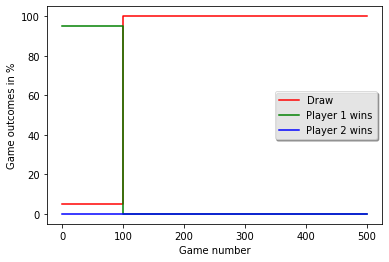

In [ ]:
player1 = MinMaxAgent()
player2 = TQPlayer()
eval_players(player1, player2,5)
#5 is the number of battles

The Tabular Q-learning player learns to play optimally against the deterministic MinMax agent in less than 100 games. Let's see how it does against the non-deterministic Min Max Agent:

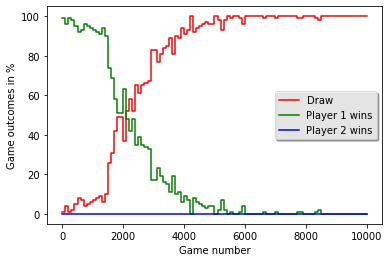

In [ ]:
player1 = RndMinMaxAgent()
player2 = TQPlayer()
eval_players(player1, player2, 100)

TQPlayer i.e. Player2 is struggling quite a bit more now, needing about 6000 games to learn a close to perfect strategy. Let's see how the initial values of the Q function impact things. First, let's initialize with 1.0:

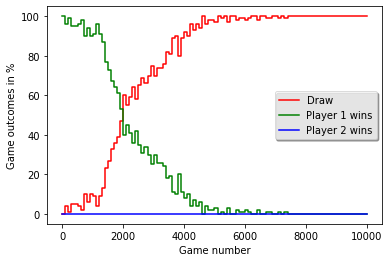

In [ ]:
player1 = RndMinMaxAgent()
player2 = TQPlayer(q_init=1.0)
eval_players(player1, player2, 100)

Observation :

Not worse, but the learning progress is a little less smooth. 

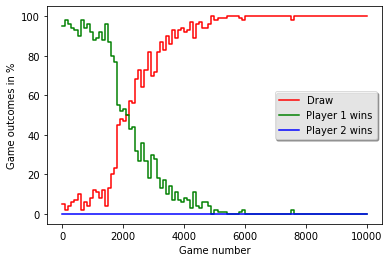

In [ ]:
player1 = RndMinMaxAgent()
player2 = TQPlayer(q_init=0.5)
eval_players(player1, player2, 100)

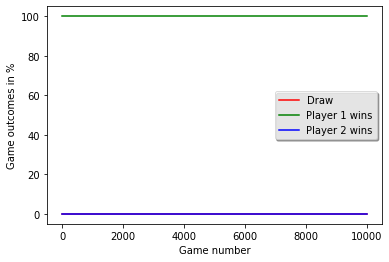

In [ ]:
player1 = RndMinMaxAgent()
player2 = TQPlayer(q_init=0)
eval_players(player1, player2, 100)

Let's try initial values of close to 0 (setting it to 0 will not work with our current code as a loss would not decrease the value further, i.e. once it choses a losing strategy it will never play anything else):

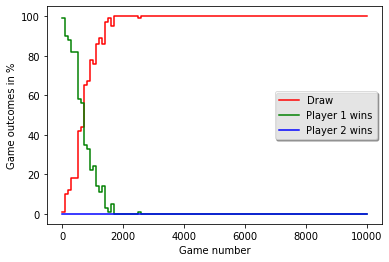

In [ ]:
player1 = RndMinMaxAgent()
player2 = TQPlayer(q_init=0.001)
eval_players(player1, player2, 100)

In contrast to the previous one, where the player was expecting to win and tried every possible way to achieve this, this time the player is quite happy to achieve a draw and settles for it much more quickly.

We try and experiement to know if a TQPlayer can learn from itself.

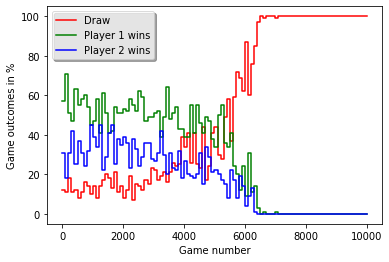

In [ ]:
player1 = TQPlayer()
player2 = TQPlayer()
eval_players(player1, player2, 100)

Yes, after about 7000 games, it seems it has found a strategy to not lose against itself. How does this trained player do against a Min Max?

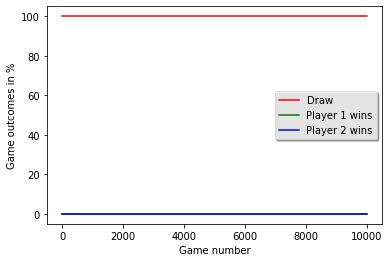

In [ ]:
player1 = RndMinMaxAgent()

eval_players(player1, player2, 100)

Even against the Min Max player, which it has never played before, it does not lose any games. We created a player that can, just by playing against itself, learn how to play Tic Tac Toe perfectly against a Min Max opponent.

Now, how does it perform against a RandomPlayer:

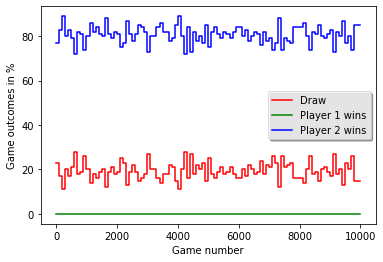

In [ ]:
player3 = RandomPlayer()

eval_players(player3, player2, 100)

Again, no losses. It actually wins quite a lot of games now. 

One last thing we'll try is training a new TQPlayer against a Random Player:

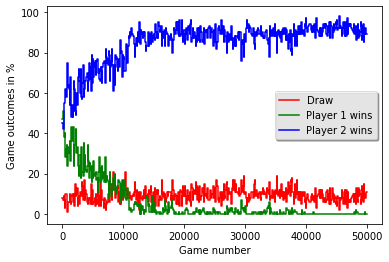

In [ ]:
player3 = RandomPlayer() #This player plays first
player2 = TQPlayer()
eval_players(player3, player2, 500)

Observation:

Even after 50,000 games, it still loses the odd game. However, it does seem to win more games against the Random Player based on this strategy than with the no-loss strategy from before. Statiscally it does better than the conservative no-loss strategy. I.e. it found some situations where, when it plays a move that may cause it to lose the game, chances are that the Random Player will make a mistake and it will actually win. It seems to be inclined to take this risk in certain situations.

## Conclusions TQPlayer vs Min Max

Both players have a severe limitation: They are only feasible for games with a small number of states. The Min Max player needs to be able to traverse the tree of possible continuations which is not feasible if there are as many as there are in Chess or Go. The TQPlayer needs to store the Q values for every state, which is also not feasible for games like chess or go.

The Min Max player has the advantage that it plays perfectly from the start. No need to learn anything. The TQPlayer on the other hand needs to play a lot of games to play well.

The TQPlayer however is able to learn effective strategies against opponents which play less than perfect. Min Max always assumes the opponent will make the best possible move in every situation. If that's not the case, the Min Max player is not able to exploit this flaw in its opponent. The TQPlayer however is more flexible and can learn an optimal stragegy against any opponent.
